E20. project-Segmentation_Map
===
---

## 목표
Segmentation Map 데이터를 이용하여 Pix2Pix를 학습시켜 결과이미지를 출력해보자.

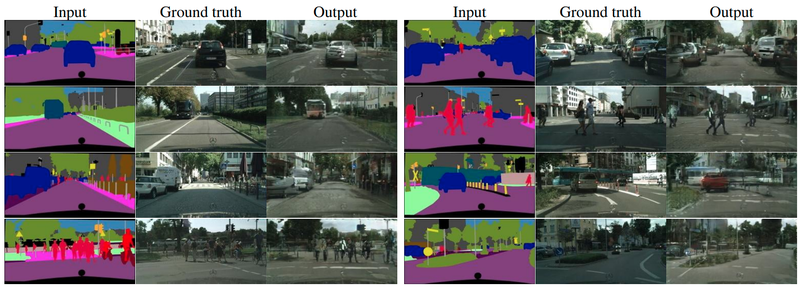

<br/>
<br/>

#### 데이터 불러오기 및 데이터 수 확인

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


> 1000개 이미지가 있음을 확인

#### 각각의 이미지들이 어떻게 생겼는지 확인( 임의로 6장을 선택하여 시각화)

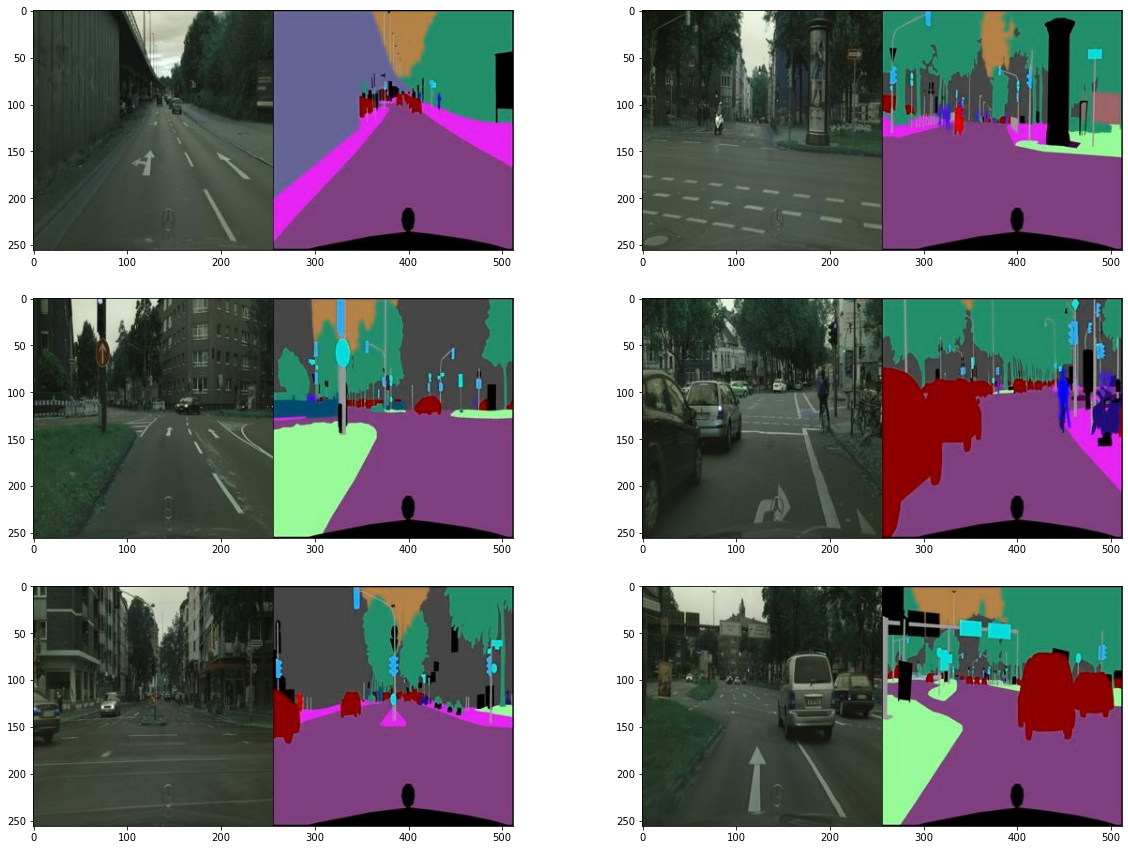

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

> 실제 사진과 함께 레이블 정보 이미지가 함께 붙어 있음

#### 이미지를 하나 열어 아래와 같이 크기를 확인

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


> (256, 512, 3)으로 확인되어 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할이 필요함

#### (256, 256, 3) 크기의 2개 이미지로 분할

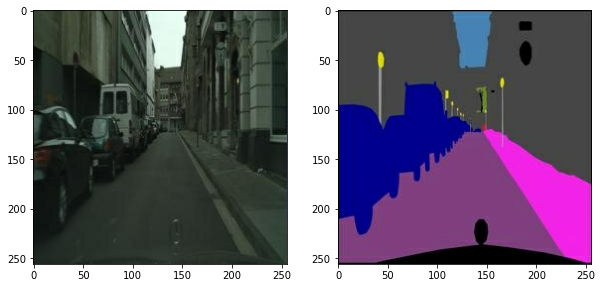

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

#### 학습에 사용하는 데이터의 다양성을 높이기 위해 여러 augmentation 방법을 적용

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


### mission 1. 필수로 수행해야할 Agumentation :: 아래의 5가지를 적용
- tf.pad :: 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용

- tf.image.random_crop :: (256,256,6) 크기를 가진 이미지를 임의로 잘라냄

- tf.image.random_flip_left_right :: 50% 확률로 가로로 뒤집음

- tf.image.random_flip_up_down :: 50% 확률로 세로로 뒤집음

- tf.image.rot90 ::  50% 확률로 회전시킴

#### Agumentation을 수행한 이미지들을 출력

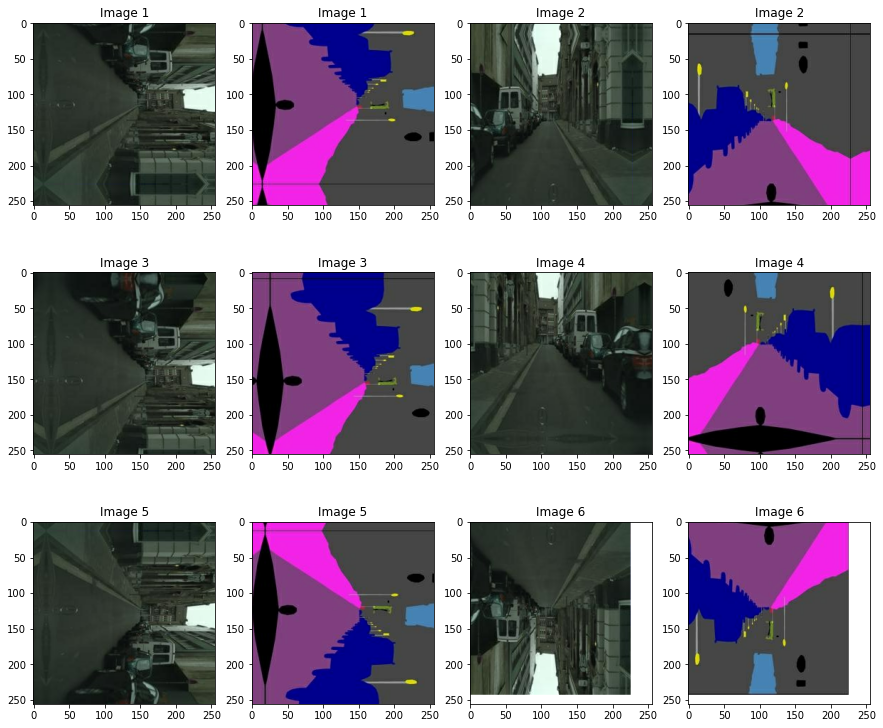

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

#### 잘 적용되었는지 하나의 이미지만 시각화하여 확인

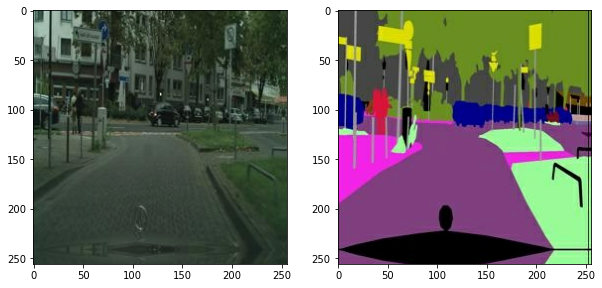

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### Generator 구현하기

#### 1) "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 하나의 레이어로 만들기

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


#### 2) 여러 번 가져다가 Encoder로 만들어 사용

In [9]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


#### 3) Encoder model설계

In [10]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

> 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인 할 수 있음

### Decoder를 구현

#### 1) Decoder 블럭 만들기
#### 2) Decoder 블럭 쌓기

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


> 처음 세 개의 블록에서만 `Dropout`을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있음

#### Decoder model 설계

In [12]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

> (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력되었음.

#### tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성

In [13]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


> Generator를 잘 작동시키기 위해서는 약 4000만 개의 파라미터를 학습시켜야 함

#### Encoder 및 Decoder에 사용되는 기본적인 블록

In [14]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


#### U-Net Generator를 정의 (skip connection)

In [15]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


### mission 2. U-net generator 사용

#### U-net의 출력을 확인

In [16]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

#### Discriminator에 사용할 기본적인 블록 만들기

In [17]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


#### 간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인

In [18]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


#### Discriminator를 만들어보기

In [19]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


#### 각 블록의 출력 크기가 알맞게 되었는지 확인

In [20]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

> 두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었고, 아래의 Discriminator를 나타낸 그림과 각 출력 크기가 일치함을 확인할 수 있음

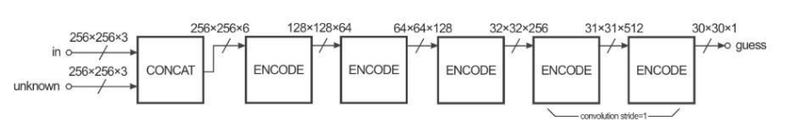

#### (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화

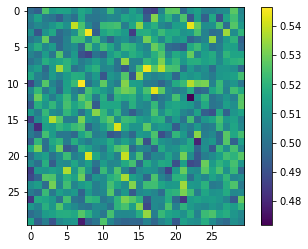

In [21]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

#### 두 가지 손실 함수를 모두 사용

In [22]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


> Generator 및 Discriminator의 손실 계산을 각각 정의하였다.

#### 사용할 optimizer는 논문과 동일하게 설정

In [23]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


#### 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정

In [24]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


### Mission 5. 중간 손실 값에 대한 로그 남기기

#### 10 epoch 학습

In [25]:
EPOCHS = 150

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)

                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
            

EPOCH[1] - STEP[10]                     
Generator_loss:0.8894                     
L1_loss:0.3578                     
Discriminator_loss:1.2048

EPOCH[1] - STEP[20]                     
Generator_loss:1.0622                     
L1_loss:0.3111                     
Discriminator_loss:1.1310

EPOCH[1] - STEP[30]                     
Generator_loss:1.2536                     
L1_loss:0.3214                     
Discriminator_loss:0.9089

EPOCH[1] - STEP[40]                     
Generator_loss:1.5586                     
L1_loss:0.2697                     
Discriminator_loss:0.8630

EPOCH[1] - STEP[50]                     
Generator_loss:1.6604                     
L1_loss:0.2510                     
Discriminator_loss:0.5506

EPOCH[1] - STEP[60]                     
Generator_loss:1.5707                     
L1_loss:0.2726                     
Discriminator_loss:0.5639

EPOCH[1] - STEP[70]                     
Generator_loss:1.8942                     
L1_loss:0.2682                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.1146                     
L1_loss:0.1525                     
Discriminator_loss:0.6331

EPOCH[3] - STEP[80]                     
Generator_loss:3.1786                     
L1_loss:0.1916                     
Discriminator_loss:0.3831

EPOCH[3] - STEP[90]                     
Generator_loss:2.5973                     
L1_loss:0.2139                     
Discriminator_loss:0.6862

EPOCH[3] - STEP[100]                     
Generator_loss:1.8185                     
L1_loss:0.1978                     
Discriminator_loss:0.7206

EPOCH[3] - STEP[110]                     
Generator_loss:2.1088                     
L1_loss:0.1843                     
Discriminator_loss:2.0040

EPOCH[3] - STEP[120]                     
Generator_loss:2.1594                     
L1_loss:0.2097                     
Discriminator_loss:0.9440

EPOCH[3] - STEP[130]                     
Generator_loss:1.5920                     
L1_loss:0.2159                

EPOCH[5] - STEP[130]                     
Generator_loss:2.5451                     
L1_loss:0.1889                     
Discriminator_loss:0.9527

EPOCH[5] - STEP[140]                     
Generator_loss:0.4724                     
L1_loss:0.1912                     
Discriminator_loss:1.5300

EPOCH[5] - STEP[150]                     
Generator_loss:2.1444                     
L1_loss:0.1894                     
Discriminator_loss:0.8089

EPOCH[5] - STEP[160]                     
Generator_loss:1.9436                     
L1_loss:0.1731                     
Discriminator_loss:0.8803

EPOCH[5] - STEP[170]                     
Generator_loss:2.2830                     
L1_loss:0.2439                     
Discriminator_loss:0.2321

EPOCH[5] - STEP[180]                     
Generator_loss:1.8629                     
L1_loss:0.2106                     
Discriminator_loss:0.9055

EPOCH[5] - STEP[190]                     
Generator_loss:1.3891                     
L1_loss:0.1782             

EPOCH[7] - STEP[190]                     
Generator_loss:2.1132                     
L1_loss:0.1763                     
Discriminator_loss:0.7698

EPOCH[7] - STEP[200]                     
Generator_loss:1.7739                     
L1_loss:0.1391                     
Discriminator_loss:0.4697

EPOCH[7] - STEP[210]                     
Generator_loss:2.0411                     
L1_loss:0.2027                     
Discriminator_loss:0.3593

EPOCH[7] - STEP[220]                     
Generator_loss:2.1907                     
L1_loss:0.1863                     
Discriminator_loss:0.8671

EPOCH[7] - STEP[230]                     
Generator_loss:2.6884                     
L1_loss:0.1848                     
Discriminator_loss:0.5084

EPOCH[7] - STEP[240]                     
Generator_loss:2.0050                     
L1_loss:0.1567                     
Discriminator_loss:2.2707

EPOCH[7] - STEP[250]                     
Generator_loss:1.1199                     
L1_loss:0.1681             

EPOCH[9] - STEP[250]                     
Generator_loss:0.2925                     
L1_loss:0.1847                     
Discriminator_loss:1.8133

EPOCH[10] - STEP[10]                     
Generator_loss:4.0318                     
L1_loss:0.1637                     
Discriminator_loss:2.9615

EPOCH[10] - STEP[20]                     
Generator_loss:1.5896                     
L1_loss:0.1515                     
Discriminator_loss:0.7504

EPOCH[10] - STEP[30]                     
Generator_loss:1.8215                     
L1_loss:0.1756                     
Discriminator_loss:0.5011

EPOCH[10] - STEP[40]                     
Generator_loss:1.8307                     
L1_loss:0.2097                     
Discriminator_loss:0.6944

EPOCH[10] - STEP[50]                     
Generator_loss:1.9859                     
L1_loss:0.1866                     
Discriminator_loss:0.4417

EPOCH[10] - STEP[60]                     
Generator_loss:1.1513                     
L1_loss:0.1913             

EPOCH[12] - STEP[60]                     
Generator_loss:2.0445                     
L1_loss:0.1463                     
Discriminator_loss:1.1586

EPOCH[12] - STEP[70]                     
Generator_loss:2.3400                     
L1_loss:0.1782                     
Discriminator_loss:0.4611

EPOCH[12] - STEP[80]                     
Generator_loss:1.0706                     
L1_loss:0.1614                     
Discriminator_loss:0.6435

EPOCH[12] - STEP[90]                     
Generator_loss:2.4299                     
L1_loss:0.1435                     
Discriminator_loss:0.9135

EPOCH[12] - STEP[100]                     
Generator_loss:2.0608                     
L1_loss:0.2056                     
Discriminator_loss:0.3617

EPOCH[12] - STEP[110]                     
Generator_loss:3.1523                     
L1_loss:0.1746                     
Discriminator_loss:0.5942

EPOCH[12] - STEP[120]                     
Generator_loss:3.6592                     
L1_loss:0.1785          

EPOCH[14] - STEP[120]                     
Generator_loss:2.4464                     
L1_loss:0.1687                     
Discriminator_loss:0.4114

EPOCH[14] - STEP[130]                     
Generator_loss:1.0206                     
L1_loss:0.1836                     
Discriminator_loss:0.6147

EPOCH[14] - STEP[140]                     
Generator_loss:1.6924                     
L1_loss:0.2315                     
Discriminator_loss:0.4235

EPOCH[14] - STEP[150]                     
Generator_loss:1.8174                     
L1_loss:0.1709                     
Discriminator_loss:0.6296

EPOCH[14] - STEP[160]                     
Generator_loss:2.5111                     
L1_loss:0.1811                     
Discriminator_loss:0.3576

EPOCH[14] - STEP[170]                     
Generator_loss:2.7983                     
L1_loss:0.1419                     
Discriminator_loss:1.5892

EPOCH[14] - STEP[180]                     
Generator_loss:2.5564                     
L1_loss:0.1537      

EPOCH[16] - STEP[180]                     
Generator_loss:3.3092                     
L1_loss:0.2056                     
Discriminator_loss:1.3543

EPOCH[16] - STEP[190]                     
Generator_loss:1.5502                     
L1_loss:0.1458                     
Discriminator_loss:0.5640

EPOCH[16] - STEP[200]                     
Generator_loss:1.7684                     
L1_loss:0.1797                     
Discriminator_loss:0.6976

EPOCH[16] - STEP[210]                     
Generator_loss:2.7843                     
L1_loss:0.1782                     
Discriminator_loss:0.5478

EPOCH[16] - STEP[220]                     
Generator_loss:2.1389                     
L1_loss:0.1655                     
Discriminator_loss:0.2782

EPOCH[16] - STEP[230]                     
Generator_loss:2.2623                     
L1_loss:0.1405                     
Discriminator_loss:1.4329

EPOCH[16] - STEP[240]                     
Generator_loss:2.1182                     
L1_loss:0.1352      

EPOCH[18] - STEP[240]                     
Generator_loss:1.1355                     
L1_loss:0.1679                     
Discriminator_loss:0.9219

EPOCH[18] - STEP[250]                     
Generator_loss:2.3723                     
L1_loss:0.1723                     
Discriminator_loss:0.2789

EPOCH[19] - STEP[10]                     
Generator_loss:3.4315                     
L1_loss:0.1790                     
Discriminator_loss:0.7417

EPOCH[19] - STEP[20]                     
Generator_loss:0.8359                     
L1_loss:0.1380                     
Discriminator_loss:0.8728

EPOCH[19] - STEP[30]                     
Generator_loss:2.8055                     
L1_loss:0.1769                     
Discriminator_loss:0.1661

EPOCH[19] - STEP[40]                     
Generator_loss:2.3425                     
L1_loss:0.1396                     
Discriminator_loss:1.1202

EPOCH[19] - STEP[50]                     
Generator_loss:2.6134                     
L1_loss:0.1743           

EPOCH[21] - STEP[50]                     
Generator_loss:2.4842                     
L1_loss:0.1496                     
Discriminator_loss:0.3917

EPOCH[21] - STEP[60]                     
Generator_loss:1.8351                     
L1_loss:0.1155                     
Discriminator_loss:1.1939

EPOCH[21] - STEP[70]                     
Generator_loss:1.6392                     
L1_loss:0.1785                     
Discriminator_loss:0.3258

EPOCH[21] - STEP[80]                     
Generator_loss:2.8906                     
L1_loss:0.1735                     
Discriminator_loss:0.7860

EPOCH[21] - STEP[90]                     
Generator_loss:2.3002                     
L1_loss:0.1544                     
Discriminator_loss:0.3706

EPOCH[21] - STEP[100]                     
Generator_loss:0.1814                     
L1_loss:0.1680                     
Discriminator_loss:2.2031

EPOCH[21] - STEP[110]                     
Generator_loss:1.3814                     
L1_loss:0.1922           

EPOCH[23] - STEP[110]                     
Generator_loss:1.7940                     
L1_loss:0.1489                     
Discriminator_loss:0.4054

EPOCH[23] - STEP[120]                     
Generator_loss:0.9050                     
L1_loss:0.1418                     
Discriminator_loss:0.8581

EPOCH[23] - STEP[130]                     
Generator_loss:0.9464                     
L1_loss:0.1445                     
Discriminator_loss:0.9864

EPOCH[23] - STEP[140]                     
Generator_loss:1.0221                     
L1_loss:0.1337                     
Discriminator_loss:0.7043

EPOCH[23] - STEP[150]                     
Generator_loss:2.2881                     
L1_loss:0.1523                     
Discriminator_loss:0.5607

EPOCH[23] - STEP[160]                     
Generator_loss:1.8301                     
L1_loss:0.1431                     
Discriminator_loss:0.9506

EPOCH[23] - STEP[170]                     
Generator_loss:1.2116                     
L1_loss:0.1570      

EPOCH[25] - STEP[170]                     
Generator_loss:1.0609                     
L1_loss:0.2071                     
Discriminator_loss:0.8522

EPOCH[25] - STEP[180]                     
Generator_loss:3.5223                     
L1_loss:0.1384                     
Discriminator_loss:0.7234

EPOCH[25] - STEP[190]                     
Generator_loss:2.8427                     
L1_loss:0.2173                     
Discriminator_loss:0.0962

EPOCH[25] - STEP[200]                     
Generator_loss:0.8805                     
L1_loss:0.1793                     
Discriminator_loss:0.8520

EPOCH[25] - STEP[210]                     
Generator_loss:1.4141                     
L1_loss:0.1664                     
Discriminator_loss:0.3693

EPOCH[25] - STEP[220]                     
Generator_loss:1.6941                     
L1_loss:0.1509                     
Discriminator_loss:0.3131

EPOCH[25] - STEP[230]                     
Generator_loss:3.9503                     
L1_loss:0.1647      

EPOCH[27] - STEP[230]                     
Generator_loss:3.2345                     
L1_loss:0.1422                     
Discriminator_loss:0.3543

EPOCH[27] - STEP[240]                     
Generator_loss:1.2825                     
L1_loss:0.1453                     
Discriminator_loss:0.9459

EPOCH[27] - STEP[250]                     
Generator_loss:3.1793                     
L1_loss:0.1900                     
Discriminator_loss:0.3223

EPOCH[28] - STEP[10]                     
Generator_loss:1.6829                     
L1_loss:0.1561                     
Discriminator_loss:0.5004

EPOCH[28] - STEP[20]                     
Generator_loss:2.6215                     
L1_loss:0.1373                     
Discriminator_loss:0.3000

EPOCH[28] - STEP[30]                     
Generator_loss:3.8112                     
L1_loss:0.1555                     
Discriminator_loss:0.6548

EPOCH[28] - STEP[40]                     
Generator_loss:1.8368                     
L1_loss:0.1389          

EPOCH[30] - STEP[40]                     
Generator_loss:2.5416                     
L1_loss:0.2203                     
Discriminator_loss:0.1237

EPOCH[30] - STEP[50]                     
Generator_loss:0.4859                     
L1_loss:0.1671                     
Discriminator_loss:1.2708

EPOCH[30] - STEP[60]                     
Generator_loss:1.2966                     
L1_loss:0.1510                     
Discriminator_loss:0.5639

EPOCH[30] - STEP[70]                     
Generator_loss:3.6556                     
L1_loss:0.1778                     
Discriminator_loss:0.0712

EPOCH[30] - STEP[80]                     
Generator_loss:1.7944                     
L1_loss:0.1596                     
Discriminator_loss:0.5976

EPOCH[30] - STEP[90]                     
Generator_loss:1.6915                     
L1_loss:0.1502                     
Discriminator_loss:0.5641

EPOCH[30] - STEP[100]                     
Generator_loss:0.5648                     
L1_loss:0.1465            

EPOCH[32] - STEP[100]                     
Generator_loss:2.2382                     
L1_loss:0.1024                     
Discriminator_loss:1.8184

EPOCH[32] - STEP[110]                     
Generator_loss:3.3732                     
L1_loss:0.1545                     
Discriminator_loss:0.1784

EPOCH[32] - STEP[120]                     
Generator_loss:1.0761                     
L1_loss:0.1653                     
Discriminator_loss:0.6529

EPOCH[32] - STEP[130]                     
Generator_loss:1.7313                     
L1_loss:0.1623                     
Discriminator_loss:0.4731

EPOCH[32] - STEP[140]                     
Generator_loss:3.8604                     
L1_loss:0.1669                     
Discriminator_loss:0.2365

EPOCH[32] - STEP[150]                     
Generator_loss:5.9189                     
L1_loss:0.1472                     
Discriminator_loss:1.9397

EPOCH[32] - STEP[160]                     
Generator_loss:3.5633                     
L1_loss:0.1601      

EPOCH[34] - STEP[160]                     
Generator_loss:2.5777                     
L1_loss:0.1567                     
Discriminator_loss:0.4344

EPOCH[34] - STEP[170]                     
Generator_loss:1.5488                     
L1_loss:0.1633                     
Discriminator_loss:0.5641

EPOCH[34] - STEP[180]                     
Generator_loss:1.6115                     
L1_loss:0.2395                     
Discriminator_loss:0.3754

EPOCH[34] - STEP[190]                     
Generator_loss:3.0910                     
L1_loss:0.1659                     
Discriminator_loss:0.1741

EPOCH[34] - STEP[200]                     
Generator_loss:3.0895                     
L1_loss:0.2066                     
Discriminator_loss:0.1874

EPOCH[34] - STEP[210]                     
Generator_loss:0.7633                     
L1_loss:0.1438                     
Discriminator_loss:0.8449

EPOCH[34] - STEP[220]                     
Generator_loss:2.3602                     
L1_loss:0.1401      

EPOCH[36] - STEP[220]                     
Generator_loss:2.2071                     
L1_loss:0.1873                     
Discriminator_loss:0.1833

EPOCH[36] - STEP[230]                     
Generator_loss:2.5929                     
L1_loss:0.1445                     
Discriminator_loss:0.3499

EPOCH[36] - STEP[240]                     
Generator_loss:1.8001                     
L1_loss:0.1836                     
Discriminator_loss:0.3240

EPOCH[36] - STEP[250]                     
Generator_loss:1.2190                     
L1_loss:0.2015                     
Discriminator_loss:0.4652

EPOCH[37] - STEP[10]                     
Generator_loss:4.0255                     
L1_loss:0.1759                     
Discriminator_loss:0.3418

EPOCH[37] - STEP[20]                     
Generator_loss:3.0302                     
L1_loss:0.1442                     
Discriminator_loss:0.7210

EPOCH[37] - STEP[30]                     
Generator_loss:2.3858                     
L1_loss:0.1638         

EPOCH[39] - STEP[30]                     
Generator_loss:3.4809                     
L1_loss:0.1317                     
Discriminator_loss:1.3224

EPOCH[39] - STEP[40]                     
Generator_loss:3.2722                     
L1_loss:0.1491                     
Discriminator_loss:0.5351

EPOCH[39] - STEP[50]                     
Generator_loss:3.2542                     
L1_loss:0.1285                     
Discriminator_loss:0.8586

EPOCH[39] - STEP[60]                     
Generator_loss:1.8604                     
L1_loss:0.1439                     
Discriminator_loss:0.2926

EPOCH[39] - STEP[70]                     
Generator_loss:0.3942                     
L1_loss:0.1363                     
Discriminator_loss:1.5691

EPOCH[39] - STEP[80]                     
Generator_loss:1.8433                     
L1_loss:0.1463                     
Discriminator_loss:0.8989

EPOCH[39] - STEP[90]                     
Generator_loss:1.4983                     
L1_loss:0.1394             

EPOCH[41] - STEP[90]                     
Generator_loss:3.1637                     
L1_loss:0.1529                     
Discriminator_loss:0.8265

EPOCH[41] - STEP[100]                     
Generator_loss:1.5666                     
L1_loss:0.1284                     
Discriminator_loss:0.5977

EPOCH[41] - STEP[110]                     
Generator_loss:4.5450                     
L1_loss:0.1507                     
Discriminator_loss:0.3268

EPOCH[41] - STEP[120]                     
Generator_loss:3.1796                     
L1_loss:0.1435                     
Discriminator_loss:0.5609

EPOCH[41] - STEP[130]                     
Generator_loss:2.4253                     
L1_loss:0.1740                     
Discriminator_loss:0.2006

EPOCH[41] - STEP[140]                     
Generator_loss:0.9172                     
L1_loss:0.1416                     
Discriminator_loss:0.8367

EPOCH[41] - STEP[150]                     
Generator_loss:3.8738                     
L1_loss:0.1446       

EPOCH[43] - STEP[150]                     
Generator_loss:2.6374                     
L1_loss:0.1491                     
Discriminator_loss:0.4202

EPOCH[43] - STEP[160]                     
Generator_loss:1.1833                     
L1_loss:0.1405                     
Discriminator_loss:0.6116

EPOCH[43] - STEP[170]                     
Generator_loss:0.3163                     
L1_loss:0.1399                     
Discriminator_loss:1.7655

EPOCH[43] - STEP[180]                     
Generator_loss:3.0143                     
L1_loss:0.1206                     
Discriminator_loss:0.4769

EPOCH[43] - STEP[190]                     
Generator_loss:1.5611                     
L1_loss:0.1359                     
Discriminator_loss:0.5485

EPOCH[43] - STEP[200]                     
Generator_loss:1.7592                     
L1_loss:0.1572                     
Discriminator_loss:0.4146

EPOCH[43] - STEP[210]                     
Generator_loss:1.4959                     
L1_loss:0.1881      

EPOCH[45] - STEP[210]                     
Generator_loss:1.2119                     
L1_loss:0.1523                     
Discriminator_loss:0.6284

EPOCH[45] - STEP[220]                     
Generator_loss:1.6695                     
L1_loss:0.1325                     
Discriminator_loss:0.3852

EPOCH[45] - STEP[230]                     
Generator_loss:2.4162                     
L1_loss:0.1410                     
Discriminator_loss:0.3593

EPOCH[45] - STEP[240]                     
Generator_loss:1.7624                     
L1_loss:0.1323                     
Discriminator_loss:0.5113

EPOCH[45] - STEP[250]                     
Generator_loss:2.5120                     
L1_loss:0.2052                     
Discriminator_loss:0.1515

EPOCH[46] - STEP[10]                     
Generator_loss:0.6374                     
L1_loss:0.1451                     
Discriminator_loss:1.0482

EPOCH[46] - STEP[20]                     
Generator_loss:5.4284                     
L1_loss:0.1507        

EPOCH[48] - STEP[20]                     
Generator_loss:4.2221                     
L1_loss:0.1448                     
Discriminator_loss:0.1339

EPOCH[48] - STEP[30]                     
Generator_loss:2.8717                     
L1_loss:0.1348                     
Discriminator_loss:0.4738

EPOCH[48] - STEP[40]                     
Generator_loss:4.9177                     
L1_loss:0.1709                     
Discriminator_loss:0.0904

EPOCH[48] - STEP[50]                     
Generator_loss:1.1105                     
L1_loss:0.1510                     
Discriminator_loss:0.6283

EPOCH[48] - STEP[60]                     
Generator_loss:3.4056                     
L1_loss:0.1791                     
Discriminator_loss:0.1402

EPOCH[48] - STEP[70]                     
Generator_loss:2.9942                     
L1_loss:0.1607                     
Discriminator_loss:0.1248

EPOCH[48] - STEP[80]                     
Generator_loss:2.2305                     
L1_loss:0.1894             

EPOCH[50] - STEP[80]                     
Generator_loss:3.5564                     
L1_loss:0.1316                     
Discriminator_loss:0.4422

EPOCH[50] - STEP[90]                     
Generator_loss:3.7004                     
L1_loss:0.1901                     
Discriminator_loss:0.1216

EPOCH[50] - STEP[100]                     
Generator_loss:4.7279                     
L1_loss:0.1251                     
Discriminator_loss:0.8506

EPOCH[50] - STEP[110]                     
Generator_loss:2.2005                     
L1_loss:0.1357                     
Discriminator_loss:0.3037

EPOCH[50] - STEP[120]                     
Generator_loss:3.2538                     
L1_loss:0.1412                     
Discriminator_loss:0.1690

EPOCH[50] - STEP[130]                     
Generator_loss:3.9075                     
L1_loss:0.1640                     
Discriminator_loss:0.2774

EPOCH[50] - STEP[140]                     
Generator_loss:1.5640                     
L1_loss:0.1575        

EPOCH[52] - STEP[140]                     
Generator_loss:2.9382                     
L1_loss:0.1526                     
Discriminator_loss:0.1392

EPOCH[52] - STEP[150]                     
Generator_loss:5.0194                     
L1_loss:0.1216                     
Discriminator_loss:1.3143

EPOCH[52] - STEP[160]                     
Generator_loss:1.4726                     
L1_loss:0.1341                     
Discriminator_loss:0.4262

EPOCH[52] - STEP[170]                     
Generator_loss:0.9787                     
L1_loss:0.1421                     
Discriminator_loss:0.7367

EPOCH[52] - STEP[180]                     
Generator_loss:1.8251                     
L1_loss:0.1373                     
Discriminator_loss:0.4614

EPOCH[52] - STEP[190]                     
Generator_loss:3.1837                     
L1_loss:0.1625                     
Discriminator_loss:0.2535

EPOCH[52] - STEP[200]                     
Generator_loss:1.6638                     
L1_loss:0.1838      

EPOCH[54] - STEP[200]                     
Generator_loss:4.7512                     
L1_loss:0.1284                     
Discriminator_loss:0.2285

EPOCH[54] - STEP[210]                     
Generator_loss:4.5188                     
L1_loss:0.1523                     
Discriminator_loss:0.0665

EPOCH[54] - STEP[220]                     
Generator_loss:1.4434                     
L1_loss:0.1170                     
Discriminator_loss:0.6617

EPOCH[54] - STEP[230]                     
Generator_loss:2.9916                     
L1_loss:0.1254                     
Discriminator_loss:0.2542

EPOCH[54] - STEP[240]                     
Generator_loss:4.5171                     
L1_loss:0.1430                     
Discriminator_loss:1.0985

EPOCH[54] - STEP[250]                     
Generator_loss:2.6989                     
L1_loss:0.1402                     
Discriminator_loss:0.2226

EPOCH[55] - STEP[10]                     
Generator_loss:4.9278                     
L1_loss:0.1311       

EPOCH[57] - STEP[10]                     
Generator_loss:1.9552                     
L1_loss:0.1293                     
Discriminator_loss:0.4698

EPOCH[57] - STEP[20]                     
Generator_loss:2.8723                     
L1_loss:0.1629                     
Discriminator_loss:0.3735

EPOCH[57] - STEP[30]                     
Generator_loss:1.5917                     
L1_loss:0.1820                     
Discriminator_loss:0.4486

EPOCH[57] - STEP[40]                     
Generator_loss:3.5146                     
L1_loss:0.1454                     
Discriminator_loss:0.2628

EPOCH[57] - STEP[50]                     
Generator_loss:0.6965                     
L1_loss:0.1221                     
Discriminator_loss:1.0768

EPOCH[57] - STEP[60]                     
Generator_loss:0.6996                     
L1_loss:0.1451                     
Discriminator_loss:0.9347

EPOCH[57] - STEP[70]                     
Generator_loss:2.0729                     
L1_loss:0.1449             

EPOCH[59] - STEP[70]                     
Generator_loss:3.3839                     
L1_loss:0.1818                     
Discriminator_loss:0.2260

EPOCH[59] - STEP[80]                     
Generator_loss:1.5048                     
L1_loss:0.1833                     
Discriminator_loss:0.3714

EPOCH[59] - STEP[90]                     
Generator_loss:1.4707                     
L1_loss:0.1225                     
Discriminator_loss:0.6389

EPOCH[59] - STEP[100]                     
Generator_loss:4.8317                     
L1_loss:0.1354                     
Discriminator_loss:0.7712

EPOCH[59] - STEP[110]                     
Generator_loss:2.3408                     
L1_loss:0.1530                     
Discriminator_loss:0.2768

EPOCH[59] - STEP[120]                     
Generator_loss:0.5953                     
L1_loss:0.1542                     
Discriminator_loss:1.0759

EPOCH[59] - STEP[130]                     
Generator_loss:5.3941                     
L1_loss:0.1360         

EPOCH[61] - STEP[130]                     
Generator_loss:4.6967                     
L1_loss:0.1340                     
Discriminator_loss:0.8213

EPOCH[61] - STEP[140]                     
Generator_loss:5.1900                     
L1_loss:0.1718                     
Discriminator_loss:0.0562

EPOCH[61] - STEP[150]                     
Generator_loss:2.9128                     
L1_loss:0.1267                     
Discriminator_loss:0.5255

EPOCH[61] - STEP[160]                     
Generator_loss:4.4018                     
L1_loss:0.1049                     
Discriminator_loss:1.4171

EPOCH[61] - STEP[170]                     
Generator_loss:3.8448                     
L1_loss:0.1431                     
Discriminator_loss:0.1398

EPOCH[61] - STEP[180]                     
Generator_loss:0.6617                     
L1_loss:0.1652                     
Discriminator_loss:1.0685

EPOCH[61] - STEP[190]                     
Generator_loss:3.4199                     
L1_loss:0.1451      

EPOCH[63] - STEP[190]                     
Generator_loss:3.5771                     
L1_loss:0.1677                     
Discriminator_loss:0.0733

EPOCH[63] - STEP[200]                     
Generator_loss:1.6554                     
L1_loss:0.1149                     
Discriminator_loss:0.5894

EPOCH[63] - STEP[210]                     
Generator_loss:2.8847                     
L1_loss:0.1396                     
Discriminator_loss:0.1375

EPOCH[63] - STEP[220]                     
Generator_loss:3.0444                     
L1_loss:0.1415                     
Discriminator_loss:0.4025

EPOCH[63] - STEP[230]                     
Generator_loss:2.2988                     
L1_loss:0.1287                     
Discriminator_loss:0.3315

EPOCH[63] - STEP[240]                     
Generator_loss:0.5121                     
L1_loss:0.1516                     
Discriminator_loss:1.2661

EPOCH[63] - STEP[250]                     
Generator_loss:2.5589                     
L1_loss:0.1116      

EPOCH[65] - STEP[250]                     
Generator_loss:2.8056                     
L1_loss:0.1519                     
Discriminator_loss:0.2262

EPOCH[66] - STEP[10]                     
Generator_loss:3.8540                     
L1_loss:0.1211                     
Discriminator_loss:0.0894

EPOCH[66] - STEP[20]                     
Generator_loss:4.1614                     
L1_loss:0.1186                     
Discriminator_loss:0.5040

EPOCH[66] - STEP[30]                     
Generator_loss:3.4087                     
L1_loss:0.1344                     
Discriminator_loss:0.5123

EPOCH[66] - STEP[40]                     
Generator_loss:2.9943                     
L1_loss:0.1512                     
Discriminator_loss:0.7075

EPOCH[66] - STEP[50]                     
Generator_loss:6.4877                     
L1_loss:0.1310                     
Discriminator_loss:1.0205

EPOCH[66] - STEP[60]                     
Generator_loss:1.4848                     
L1_loss:0.1492            

EPOCH[68] - STEP[60]                     
Generator_loss:4.0649                     
L1_loss:0.1189                     
Discriminator_loss:0.4528

EPOCH[68] - STEP[70]                     
Generator_loss:3.7089                     
L1_loss:0.2024                     
Discriminator_loss:0.0913

EPOCH[68] - STEP[80]                     
Generator_loss:1.4354                     
L1_loss:0.1243                     
Discriminator_loss:0.6523

EPOCH[68] - STEP[90]                     
Generator_loss:2.1962                     
L1_loss:0.1353                     
Discriminator_loss:0.4935

EPOCH[68] - STEP[100]                     
Generator_loss:2.2129                     
L1_loss:0.1221                     
Discriminator_loss:0.4567

EPOCH[68] - STEP[110]                     
Generator_loss:2.5512                     
L1_loss:0.1221                     
Discriminator_loss:0.3550

EPOCH[68] - STEP[120]                     
Generator_loss:2.1867                     
L1_loss:0.1242          

EPOCH[70] - STEP[120]                     
Generator_loss:2.8430                     
L1_loss:0.1316                     
Discriminator_loss:0.2007

EPOCH[70] - STEP[130]                     
Generator_loss:2.7200                     
L1_loss:0.1570                     
Discriminator_loss:0.1741

EPOCH[70] - STEP[140]                     
Generator_loss:2.8169                     
L1_loss:0.1152                     
Discriminator_loss:0.5996

EPOCH[70] - STEP[150]                     
Generator_loss:2.8947                     
L1_loss:0.1258                     
Discriminator_loss:0.2694

EPOCH[70] - STEP[160]                     
Generator_loss:4.3456                     
L1_loss:0.1163                     
Discriminator_loss:0.5524

EPOCH[70] - STEP[170]                     
Generator_loss:3.5046                     
L1_loss:0.1872                     
Discriminator_loss:0.0939

EPOCH[70] - STEP[180]                     
Generator_loss:4.1716                     
L1_loss:0.1333      

EPOCH[72] - STEP[180]                     
Generator_loss:1.3679                     
L1_loss:0.1214                     
Discriminator_loss:0.5746

EPOCH[72] - STEP[190]                     
Generator_loss:1.2779                     
L1_loss:0.1606                     
Discriminator_loss:0.8430

EPOCH[72] - STEP[200]                     
Generator_loss:3.7565                     
L1_loss:0.1300                     
Discriminator_loss:0.1797

EPOCH[72] - STEP[210]                     
Generator_loss:4.4278                     
L1_loss:0.1394                     
Discriminator_loss:0.1510

EPOCH[72] - STEP[220]                     
Generator_loss:5.2844                     
L1_loss:0.1375                     
Discriminator_loss:0.0940

EPOCH[72] - STEP[230]                     
Generator_loss:0.8069                     
L1_loss:0.1214                     
Discriminator_loss:0.9469

EPOCH[72] - STEP[240]                     
Generator_loss:4.4887                     
L1_loss:0.1402      

EPOCH[74] - STEP[240]                     
Generator_loss:5.9053                     
L1_loss:0.1330                     
Discriminator_loss:0.2035

EPOCH[74] - STEP[250]                     
Generator_loss:4.3204                     
L1_loss:0.1429                     
Discriminator_loss:0.1638

EPOCH[75] - STEP[10]                     
Generator_loss:3.9001                     
L1_loss:0.1329                     
Discriminator_loss:0.0517

EPOCH[75] - STEP[20]                     
Generator_loss:3.2610                     
L1_loss:0.1789                     
Discriminator_loss:0.1059

EPOCH[75] - STEP[30]                     
Generator_loss:6.1545                     
L1_loss:0.1195                     
Discriminator_loss:0.6098

EPOCH[75] - STEP[40]                     
Generator_loss:4.0471                     
L1_loss:0.1291                     
Discriminator_loss:0.7021

EPOCH[75] - STEP[50]                     
Generator_loss:3.0099                     
L1_loss:0.1496           

EPOCH[77] - STEP[50]                     
Generator_loss:1.7690                     
L1_loss:0.1134                     
Discriminator_loss:0.4039

EPOCH[77] - STEP[60]                     
Generator_loss:3.3232                     
L1_loss:0.1431                     
Discriminator_loss:0.1518

EPOCH[77] - STEP[70]                     
Generator_loss:3.9900                     
L1_loss:0.1045                     
Discriminator_loss:0.2528

EPOCH[77] - STEP[80]                     
Generator_loss:6.3425                     
L1_loss:0.1195                     
Discriminator_loss:1.4657

EPOCH[77] - STEP[90]                     
Generator_loss:1.5214                     
L1_loss:0.1149                     
Discriminator_loss:0.4490

EPOCH[77] - STEP[100]                     
Generator_loss:1.7633                     
L1_loss:0.1280                     
Discriminator_loss:0.5884

EPOCH[77] - STEP[110]                     
Generator_loss:1.7357                     
L1_loss:0.1217           

EPOCH[79] - STEP[110]                     
Generator_loss:4.1976                     
L1_loss:0.1907                     
Discriminator_loss:0.1104

EPOCH[79] - STEP[120]                     
Generator_loss:2.1803                     
L1_loss:0.1236                     
Discriminator_loss:0.4577

EPOCH[79] - STEP[130]                     
Generator_loss:6.1099                     
L1_loss:0.1462                     
Discriminator_loss:0.1680

EPOCH[79] - STEP[140]                     
Generator_loss:1.7816                     
L1_loss:0.1116                     
Discriminator_loss:0.3826

EPOCH[79] - STEP[150]                     
Generator_loss:4.1702                     
L1_loss:0.1720                     
Discriminator_loss:0.0365

EPOCH[79] - STEP[160]                     
Generator_loss:5.2855                     
L1_loss:0.1113                     
Discriminator_loss:0.1001

EPOCH[79] - STEP[170]                     
Generator_loss:2.0326                     
L1_loss:0.1235      

EPOCH[81] - STEP[170]                     
Generator_loss:6.3381                     
L1_loss:0.1150                     
Discriminator_loss:0.7397

EPOCH[81] - STEP[180]                     
Generator_loss:3.5641                     
L1_loss:0.1160                     
Discriminator_loss:0.5057

EPOCH[81] - STEP[190]                     
Generator_loss:1.9534                     
L1_loss:0.1125                     
Discriminator_loss:0.4927

EPOCH[81] - STEP[200]                     
Generator_loss:3.2368                     
L1_loss:0.1056                     
Discriminator_loss:0.5152

EPOCH[81] - STEP[210]                     
Generator_loss:4.0607                     
L1_loss:0.1345                     
Discriminator_loss:0.2013

EPOCH[81] - STEP[220]                     
Generator_loss:2.9604                     
L1_loss:0.1513                     
Discriminator_loss:0.1512

EPOCH[81] - STEP[230]                     
Generator_loss:5.3941                     
L1_loss:0.1283      

EPOCH[83] - STEP[230]                     
Generator_loss:4.1535                     
L1_loss:0.1142                     
Discriminator_loss:1.0421

EPOCH[83] - STEP[240]                     
Generator_loss:7.5257                     
L1_loss:0.1383                     
Discriminator_loss:2.2241

EPOCH[83] - STEP[250]                     
Generator_loss:3.5004                     
L1_loss:0.0981                     
Discriminator_loss:0.6474

EPOCH[84] - STEP[10]                     
Generator_loss:2.0604                     
L1_loss:0.1260                     
Discriminator_loss:0.3779

EPOCH[84] - STEP[20]                     
Generator_loss:1.5092                     
L1_loss:0.1467                     
Discriminator_loss:0.4559

EPOCH[84] - STEP[30]                     
Generator_loss:5.5419                     
L1_loss:0.1291                     
Discriminator_loss:0.0991

EPOCH[84] - STEP[40]                     
Generator_loss:3.6414                     
L1_loss:0.1486          

EPOCH[86] - STEP[40]                     
Generator_loss:4.7098                     
L1_loss:0.1098                     
Discriminator_loss:0.1470

EPOCH[86] - STEP[50]                     
Generator_loss:4.6735                     
L1_loss:0.1475                     
Discriminator_loss:0.0589

EPOCH[86] - STEP[60]                     
Generator_loss:4.6891                     
L1_loss:0.1284                     
Discriminator_loss:0.0585

EPOCH[86] - STEP[70]                     
Generator_loss:6.4894                     
L1_loss:0.1719                     
Discriminator_loss:0.0391

EPOCH[86] - STEP[80]                     
Generator_loss:2.9825                     
L1_loss:0.1489                     
Discriminator_loss:0.5993

EPOCH[86] - STEP[90]                     
Generator_loss:1.6700                     
L1_loss:0.1645                     
Discriminator_loss:0.3614

EPOCH[86] - STEP[100]                     
Generator_loss:5.5947                     
L1_loss:0.1158            

EPOCH[88] - STEP[100]                     
Generator_loss:3.6918                     
L1_loss:0.1487                     
Discriminator_loss:0.0802

EPOCH[88] - STEP[110]                     
Generator_loss:5.2072                     
L1_loss:0.1458                     
Discriminator_loss:0.0619

EPOCH[88] - STEP[120]                     
Generator_loss:7.5907                     
L1_loss:0.1399                     
Discriminator_loss:0.2466

EPOCH[88] - STEP[130]                     
Generator_loss:3.7905                     
L1_loss:0.1170                     
Discriminator_loss:0.1595

EPOCH[88] - STEP[140]                     
Generator_loss:1.7880                     
L1_loss:0.1591                     
Discriminator_loss:0.4637

EPOCH[88] - STEP[150]                     
Generator_loss:3.0353                     
L1_loss:0.1322                     
Discriminator_loss:0.2774

EPOCH[88] - STEP[160]                     
Generator_loss:4.6258                     
L1_loss:0.1491      

EPOCH[90] - STEP[160]                     
Generator_loss:0.9612                     
L1_loss:0.1150                     
Discriminator_loss:0.9042

EPOCH[90] - STEP[170]                     
Generator_loss:5.8915                     
L1_loss:0.1156                     
Discriminator_loss:0.4767

EPOCH[90] - STEP[180]                     
Generator_loss:4.9646                     
L1_loss:0.1346                     
Discriminator_loss:0.3770

EPOCH[90] - STEP[190]                     
Generator_loss:5.1076                     
L1_loss:0.1365                     
Discriminator_loss:0.0389

EPOCH[90] - STEP[200]                     
Generator_loss:3.1002                     
L1_loss:0.1231                     
Discriminator_loss:0.1835

EPOCH[90] - STEP[210]                     
Generator_loss:7.4846                     
L1_loss:0.1312                     
Discriminator_loss:0.0873

EPOCH[90] - STEP[220]                     
Generator_loss:5.4964                     
L1_loss:0.1162      

EPOCH[92] - STEP[220]                     
Generator_loss:3.0926                     
L1_loss:0.1253                     
Discriminator_loss:0.1092

EPOCH[92] - STEP[230]                     
Generator_loss:2.1807                     
L1_loss:0.1197                     
Discriminator_loss:0.3420

EPOCH[92] - STEP[240]                     
Generator_loss:6.2419                     
L1_loss:0.1186                     
Discriminator_loss:0.1170

EPOCH[92] - STEP[250]                     
Generator_loss:4.4725                     
L1_loss:0.1414                     
Discriminator_loss:0.0928

EPOCH[93] - STEP[10]                     
Generator_loss:4.7840                     
L1_loss:0.1222                     
Discriminator_loss:0.1630

EPOCH[93] - STEP[20]                     
Generator_loss:3.5886                     
L1_loss:0.1398                     
Discriminator_loss:0.1899

EPOCH[93] - STEP[30]                     
Generator_loss:1.4811                     
L1_loss:0.1268         

EPOCH[95] - STEP[30]                     
Generator_loss:3.5221                     
L1_loss:0.1404                     
Discriminator_loss:0.1179

EPOCH[95] - STEP[40]                     
Generator_loss:3.3767                     
L1_loss:0.1759                     
Discriminator_loss:0.1157

EPOCH[95] - STEP[50]                     
Generator_loss:3.6627                     
L1_loss:0.1261                     
Discriminator_loss:0.1848

EPOCH[95] - STEP[60]                     
Generator_loss:5.6781                     
L1_loss:0.1573                     
Discriminator_loss:0.1294

EPOCH[95] - STEP[70]                     
Generator_loss:2.5188                     
L1_loss:0.1621                     
Discriminator_loss:0.1753

EPOCH[95] - STEP[80]                     
Generator_loss:5.3232                     
L1_loss:0.1291                     
Discriminator_loss:0.2021

EPOCH[95] - STEP[90]                     
Generator_loss:5.7889                     
L1_loss:0.1215             

EPOCH[97] - STEP[90]                     
Generator_loss:0.9051                     
L1_loss:0.1149                     
Discriminator_loss:0.8652

EPOCH[97] - STEP[100]                     
Generator_loss:6.5130                     
L1_loss:0.1475                     
Discriminator_loss:0.0614

EPOCH[97] - STEP[110]                     
Generator_loss:2.1381                     
L1_loss:0.1365                     
Discriminator_loss:0.2385

EPOCH[97] - STEP[120]                     
Generator_loss:3.0706                     
L1_loss:0.1428                     
Discriminator_loss:0.2657

EPOCH[97] - STEP[130]                     
Generator_loss:3.1796                     
L1_loss:0.1252                     
Discriminator_loss:0.1480

EPOCH[97] - STEP[140]                     
Generator_loss:3.0699                     
L1_loss:0.1631                     
Discriminator_loss:0.2646

EPOCH[97] - STEP[150]                     
Generator_loss:5.3636                     
L1_loss:0.1079       

EPOCH[99] - STEP[150]                     
Generator_loss:1.1317                     
L1_loss:0.1156                     
Discriminator_loss:0.6757

EPOCH[99] - STEP[160]                     
Generator_loss:3.9471                     
L1_loss:0.1147                     
Discriminator_loss:0.2144

EPOCH[99] - STEP[170]                     
Generator_loss:5.2923                     
L1_loss:0.1584                     
Discriminator_loss:0.0198

EPOCH[99] - STEP[180]                     
Generator_loss:4.5937                     
L1_loss:0.1596                     
Discriminator_loss:0.0889

EPOCH[99] - STEP[190]                     
Generator_loss:5.7271                     
L1_loss:0.1640                     
Discriminator_loss:0.0082

EPOCH[99] - STEP[200]                     
Generator_loss:5.0595                     
L1_loss:0.1775                     
Discriminator_loss:0.1517

EPOCH[99] - STEP[210]                     
Generator_loss:5.5406                     
L1_loss:0.1822      

EPOCH[101] - STEP[200]                     
Generator_loss:5.8893                     
L1_loss:0.1269                     
Discriminator_loss:0.2619

EPOCH[101] - STEP[210]                     
Generator_loss:5.6765                     
L1_loss:0.1333                     
Discriminator_loss:0.1997

EPOCH[101] - STEP[220]                     
Generator_loss:2.2780                     
L1_loss:0.1836                     
Discriminator_loss:0.3308

EPOCH[101] - STEP[230]                     
Generator_loss:4.1487                     
L1_loss:0.1404                     
Discriminator_loss:0.0664

EPOCH[101] - STEP[240]                     
Generator_loss:7.4509                     
L1_loss:0.1416                     
Discriminator_loss:0.0402

EPOCH[101] - STEP[250]                     
Generator_loss:7.2559                     
L1_loss:0.1236                     
Discriminator_loss:0.1689

EPOCH[102] - STEP[10]                     
Generator_loss:4.7346                     
L1_loss:0.1086

EPOCH[103] - STEP[250]                     
Generator_loss:2.8623                     
L1_loss:0.1265                     
Discriminator_loss:0.1268

EPOCH[104] - STEP[10]                     
Generator_loss:1.6542                     
L1_loss:0.1189                     
Discriminator_loss:0.3889

EPOCH[104] - STEP[20]                     
Generator_loss:2.2680                     
L1_loss:0.1415                     
Discriminator_loss:0.2139

EPOCH[104] - STEP[30]                     
Generator_loss:1.7734                     
L1_loss:0.1409                     
Discriminator_loss:0.5315

EPOCH[104] - STEP[40]                     
Generator_loss:5.7068                     
L1_loss:0.1084                     
Discriminator_loss:0.3679

EPOCH[104] - STEP[50]                     
Generator_loss:2.1231                     
L1_loss:0.1532                     
Discriminator_loss:0.2333

EPOCH[104] - STEP[60]                     
Generator_loss:9.8881                     
L1_loss:0.1622     

EPOCH[106] - STEP[50]                     
Generator_loss:3.4200                     
L1_loss:0.1882                     
Discriminator_loss:0.1075

EPOCH[106] - STEP[60]                     
Generator_loss:3.3982                     
L1_loss:0.1265                     
Discriminator_loss:0.1430

EPOCH[106] - STEP[70]                     
Generator_loss:5.1250                     
L1_loss:0.1412                     
Discriminator_loss:0.0299

EPOCH[106] - STEP[80]                     
Generator_loss:2.9910                     
L1_loss:0.1421                     
Discriminator_loss:0.2466

EPOCH[106] - STEP[90]                     
Generator_loss:6.1332                     
L1_loss:0.1380                     
Discriminator_loss:0.0863

EPOCH[106] - STEP[100]                     
Generator_loss:0.9522                     
L1_loss:0.1410                     
Discriminator_loss:0.8754

EPOCH[106] - STEP[110]                     
Generator_loss:3.7764                     
L1_loss:0.1188    

EPOCH[108] - STEP[100]                     
Generator_loss:4.7077                     
L1_loss:0.1211                     
Discriminator_loss:0.0394

EPOCH[108] - STEP[110]                     
Generator_loss:3.8128                     
L1_loss:0.1292                     
Discriminator_loss:0.0621

EPOCH[108] - STEP[120]                     
Generator_loss:5.9195                     
L1_loss:0.1485                     
Discriminator_loss:0.0246

EPOCH[108] - STEP[130]                     
Generator_loss:3.4840                     
L1_loss:0.1276                     
Discriminator_loss:0.1028

EPOCH[108] - STEP[140]                     
Generator_loss:1.2823                     
L1_loss:0.1287                     
Discriminator_loss:0.7014

EPOCH[108] - STEP[150]                     
Generator_loss:6.7800                     
L1_loss:0.1170                     
Discriminator_loss:0.7403

EPOCH[108] - STEP[160]                     
Generator_loss:1.2245                     
L1_loss:0.152

EPOCH[110] - STEP[150]                     
Generator_loss:4.5461                     
L1_loss:0.1224                     
Discriminator_loss:0.1536

EPOCH[110] - STEP[160]                     
Generator_loss:3.2755                     
L1_loss:0.1327                     
Discriminator_loss:0.1119

EPOCH[110] - STEP[170]                     
Generator_loss:6.6152                     
L1_loss:0.1337                     
Discriminator_loss:0.0189

EPOCH[110] - STEP[180]                     
Generator_loss:5.8590                     
L1_loss:0.1546                     
Discriminator_loss:0.0192

EPOCH[110] - STEP[190]                     
Generator_loss:3.9282                     
L1_loss:0.1734                     
Discriminator_loss:0.0910

EPOCH[110] - STEP[200]                     
Generator_loss:5.5749                     
L1_loss:0.1379                     
Discriminator_loss:0.0283

EPOCH[110] - STEP[210]                     
Generator_loss:5.6183                     
L1_loss:0.115

EPOCH[112] - STEP[200]                     
Generator_loss:5.9869                     
L1_loss:0.1139                     
Discriminator_loss:0.2160

EPOCH[112] - STEP[210]                     
Generator_loss:6.3304                     
L1_loss:0.1008                     
Discriminator_loss:1.3492

EPOCH[112] - STEP[220]                     
Generator_loss:7.4314                     
L1_loss:0.1172                     
Discriminator_loss:0.7507

EPOCH[112] - STEP[230]                     
Generator_loss:5.7111                     
L1_loss:0.1085                     
Discriminator_loss:0.3923

EPOCH[112] - STEP[240]                     
Generator_loss:5.3342                     
L1_loss:0.1216                     
Discriminator_loss:0.0226

EPOCH[112] - STEP[250]                     
Generator_loss:2.3483                     
L1_loss:0.1347                     
Discriminator_loss:0.2469

EPOCH[113] - STEP[10]                     
Generator_loss:3.6690                     
L1_loss:0.0991

EPOCH[114] - STEP[250]                     
Generator_loss:4.2924                     
L1_loss:0.1076                     
Discriminator_loss:1.8191

EPOCH[115] - STEP[10]                     
Generator_loss:6.4112                     
L1_loss:0.1265                     
Discriminator_loss:0.9086

EPOCH[115] - STEP[20]                     
Generator_loss:2.7539                     
L1_loss:0.1444                     
Discriminator_loss:0.2370

EPOCH[115] - STEP[30]                     
Generator_loss:5.5197                     
L1_loss:0.1212                     
Discriminator_loss:0.5504

EPOCH[115] - STEP[40]                     
Generator_loss:1.7388                     
L1_loss:0.1329                     
Discriminator_loss:0.3948

EPOCH[115] - STEP[50]                     
Generator_loss:7.6140                     
L1_loss:0.1329                     
Discriminator_loss:0.3982

EPOCH[115] - STEP[60]                     
Generator_loss:2.1644                     
L1_loss:0.1312     

EPOCH[117] - STEP[50]                     
Generator_loss:1.7098                     
L1_loss:0.1199                     
Discriminator_loss:0.4385

EPOCH[117] - STEP[60]                     
Generator_loss:2.3024                     
L1_loss:0.1301                     
Discriminator_loss:0.2990

EPOCH[117] - STEP[70]                     
Generator_loss:1.4532                     
L1_loss:0.1289                     
Discriminator_loss:0.6391

EPOCH[117] - STEP[80]                     
Generator_loss:5.4687                     
L1_loss:0.1079                     
Discriminator_loss:1.0402

EPOCH[117] - STEP[90]                     
Generator_loss:0.6774                     
L1_loss:0.1228                     
Discriminator_loss:1.3230

EPOCH[117] - STEP[100]                     
Generator_loss:3.0379                     
L1_loss:0.1246                     
Discriminator_loss:0.2969

EPOCH[117] - STEP[110]                     
Generator_loss:2.5420                     
L1_loss:0.1288    

EPOCH[119] - STEP[100]                     
Generator_loss:5.3127                     
L1_loss:0.1290                     
Discriminator_loss:0.6281

EPOCH[119] - STEP[110]                     
Generator_loss:5.2325                     
L1_loss:0.1419                     
Discriminator_loss:0.0270

EPOCH[119] - STEP[120]                     
Generator_loss:1.7572                     
L1_loss:0.1615                     
Discriminator_loss:0.4862

EPOCH[119] - STEP[130]                     
Generator_loss:1.3855                     
L1_loss:0.1212                     
Discriminator_loss:0.6555

EPOCH[119] - STEP[140]                     
Generator_loss:5.3372                     
L1_loss:0.1423                     
Discriminator_loss:0.0579

EPOCH[119] - STEP[150]                     
Generator_loss:1.0479                     
L1_loss:0.1357                     
Discriminator_loss:0.7590

EPOCH[119] - STEP[160]                     
Generator_loss:6.3744                     
L1_loss:0.154

EPOCH[121] - STEP[150]                     
Generator_loss:3.8381                     
L1_loss:0.1118                     
Discriminator_loss:0.0663

EPOCH[121] - STEP[160]                     
Generator_loss:5.9514                     
L1_loss:0.1327                     
Discriminator_loss:0.0138

EPOCH[121] - STEP[170]                     
Generator_loss:3.4822                     
L1_loss:0.1421                     
Discriminator_loss:0.0695

EPOCH[121] - STEP[180]                     
Generator_loss:3.0652                     
L1_loss:0.1346                     
Discriminator_loss:0.1027

EPOCH[121] - STEP[190]                     
Generator_loss:5.6414                     
L1_loss:0.1548                     
Discriminator_loss:0.0245

EPOCH[121] - STEP[200]                     
Generator_loss:4.0040                     
L1_loss:0.1189                     
Discriminator_loss:0.2751

EPOCH[121] - STEP[210]                     
Generator_loss:3.3115                     
L1_loss:0.133

EPOCH[123] - STEP[200]                     
Generator_loss:2.3588                     
L1_loss:0.1071                     
Discriminator_loss:0.2013

EPOCH[123] - STEP[210]                     
Generator_loss:3.4273                     
L1_loss:0.1243                     
Discriminator_loss:0.1216

EPOCH[123] - STEP[220]                     
Generator_loss:3.3344                     
L1_loss:0.1299                     
Discriminator_loss:0.0817

EPOCH[123] - STEP[230]                     
Generator_loss:7.2880                     
L1_loss:0.1189                     
Discriminator_loss:0.1912

EPOCH[123] - STEP[240]                     
Generator_loss:5.7481                     
L1_loss:0.1424                     
Discriminator_loss:0.0234

EPOCH[123] - STEP[250]                     
Generator_loss:4.4877                     
L1_loss:0.0974                     
Discriminator_loss:0.9591

EPOCH[124] - STEP[10]                     
Generator_loss:4.3374                     
L1_loss:0.1044

EPOCH[125] - STEP[250]                     
Generator_loss:2.3089                     
L1_loss:0.1229                     
Discriminator_loss:0.2707

EPOCH[126] - STEP[10]                     
Generator_loss:3.4579                     
L1_loss:0.1171                     
Discriminator_loss:0.2672

EPOCH[126] - STEP[20]                     
Generator_loss:6.3736                     
L1_loss:0.1052                     
Discriminator_loss:0.7085

EPOCH[126] - STEP[30]                     
Generator_loss:1.0569                     
L1_loss:0.1452                     
Discriminator_loss:0.9671

EPOCH[126] - STEP[40]                     
Generator_loss:3.5705                     
L1_loss:0.1384                     
Discriminator_loss:0.1971

EPOCH[126] - STEP[50]                     
Generator_loss:1.2298                     
L1_loss:0.1114                     
Discriminator_loss:0.6374

EPOCH[126] - STEP[60]                     
Generator_loss:1.6791                     
L1_loss:0.1177     

EPOCH[128] - STEP[50]                     
Generator_loss:5.5059                     
L1_loss:0.1097                     
Discriminator_loss:0.1374

EPOCH[128] - STEP[60]                     
Generator_loss:2.2801                     
L1_loss:0.1278                     
Discriminator_loss:0.3136

EPOCH[128] - STEP[70]                     
Generator_loss:4.4606                     
L1_loss:0.1152                     
Discriminator_loss:0.0297

EPOCH[128] - STEP[80]                     
Generator_loss:7.3242                     
L1_loss:0.0973                     
Discriminator_loss:0.3615

EPOCH[128] - STEP[90]                     
Generator_loss:3.9732                     
L1_loss:0.1336                     
Discriminator_loss:0.0841

EPOCH[128] - STEP[100]                     
Generator_loss:5.9795                     
L1_loss:0.1132                     
Discriminator_loss:0.3355

EPOCH[128] - STEP[110]                     
Generator_loss:6.6257                     
L1_loss:0.1046    

EPOCH[130] - STEP[100]                     
Generator_loss:7.6623                     
L1_loss:0.1213                     
Discriminator_loss:0.5187

EPOCH[130] - STEP[110]                     
Generator_loss:3.5433                     
L1_loss:0.1265                     
Discriminator_loss:0.2184

EPOCH[130] - STEP[120]                     
Generator_loss:3.2389                     
L1_loss:0.1041                     
Discriminator_loss:0.6786

EPOCH[130] - STEP[130]                     
Generator_loss:3.0082                     
L1_loss:0.1134                     
Discriminator_loss:0.1509

EPOCH[130] - STEP[140]                     
Generator_loss:5.1374                     
L1_loss:0.1149                     
Discriminator_loss:0.0382

EPOCH[130] - STEP[150]                     
Generator_loss:4.8447                     
L1_loss:0.1418                     
Discriminator_loss:0.0228

EPOCH[130] - STEP[160]                     
Generator_loss:2.2128                     
L1_loss:0.143

EPOCH[132] - STEP[150]                     
Generator_loss:3.7250                     
L1_loss:0.1279                     
Discriminator_loss:2.9425

EPOCH[132] - STEP[160]                     
Generator_loss:5.3047                     
L1_loss:0.1186                     
Discriminator_loss:1.1798

EPOCH[132] - STEP[170]                     
Generator_loss:1.8313                     
L1_loss:0.1342                     
Discriminator_loss:0.4854

EPOCH[132] - STEP[180]                     
Generator_loss:1.0271                     
L1_loss:0.1455                     
Discriminator_loss:1.2240

EPOCH[132] - STEP[190]                     
Generator_loss:1.3879                     
L1_loss:0.1184                     
Discriminator_loss:1.0313

EPOCH[132] - STEP[200]                     
Generator_loss:6.3033                     
L1_loss:0.1295                     
Discriminator_loss:0.0242

EPOCH[132] - STEP[210]                     
Generator_loss:3.3634                     
L1_loss:0.145

EPOCH[134] - STEP[200]                     
Generator_loss:3.2772                     
L1_loss:0.1228                     
Discriminator_loss:0.1008

EPOCH[134] - STEP[210]                     
Generator_loss:1.2256                     
L1_loss:0.1039                     
Discriminator_loss:0.7693

EPOCH[134] - STEP[220]                     
Generator_loss:3.0957                     
L1_loss:0.1301                     
Discriminator_loss:2.1559

EPOCH[134] - STEP[230]                     
Generator_loss:3.9143                     
L1_loss:0.1066                     
Discriminator_loss:0.7641

EPOCH[134] - STEP[240]                     
Generator_loss:3.3679                     
L1_loss:0.1378                     
Discriminator_loss:0.3479

EPOCH[134] - STEP[250]                     
Generator_loss:4.2052                     
L1_loss:0.1417                     
Discriminator_loss:0.1417

EPOCH[135] - STEP[10]                     
Generator_loss:6.4019                     
L1_loss:0.1098

EPOCH[136] - STEP[250]                     
Generator_loss:3.1427                     
L1_loss:0.1156                     
Discriminator_loss:0.0824

EPOCH[137] - STEP[10]                     
Generator_loss:2.7251                     
L1_loss:0.1257                     
Discriminator_loss:0.1946

EPOCH[137] - STEP[20]                     
Generator_loss:6.6270                     
L1_loss:0.1650                     
Discriminator_loss:0.0067

EPOCH[137] - STEP[30]                     
Generator_loss:3.7276                     
L1_loss:0.1148                     
Discriminator_loss:0.0499

EPOCH[137] - STEP[40]                     
Generator_loss:4.7458                     
L1_loss:0.1456                     
Discriminator_loss:0.2564

EPOCH[137] - STEP[50]                     
Generator_loss:5.1878                     
L1_loss:0.1037                     
Discriminator_loss:0.0802

EPOCH[137] - STEP[60]                     
Generator_loss:6.2608                     
L1_loss:0.1317     

EPOCH[139] - STEP[50]                     
Generator_loss:1.5609                     
L1_loss:0.1198                     
Discriminator_loss:0.5886

EPOCH[139] - STEP[60]                     
Generator_loss:6.7669                     
L1_loss:0.1294                     
Discriminator_loss:0.0056

EPOCH[139] - STEP[70]                     
Generator_loss:8.5933                     
L1_loss:0.1141                     
Discriminator_loss:0.2090

EPOCH[139] - STEP[80]                     
Generator_loss:4.5418                     
L1_loss:0.1416                     
Discriminator_loss:0.0377

EPOCH[139] - STEP[90]                     
Generator_loss:4.4177                     
L1_loss:0.1380                     
Discriminator_loss:0.0408

EPOCH[139] - STEP[100]                     
Generator_loss:9.1196                     
L1_loss:0.1095                     
Discriminator_loss:0.1563

EPOCH[139] - STEP[110]                     
Generator_loss:6.1346                     
L1_loss:0.1242    

EPOCH[141] - STEP[100]                     
Generator_loss:0.6644                     
L1_loss:0.1447                     
Discriminator_loss:1.1183

EPOCH[141] - STEP[110]                     
Generator_loss:8.8839                     
L1_loss:0.1145                     
Discriminator_loss:0.3094

EPOCH[141] - STEP[120]                     
Generator_loss:3.3781                     
L1_loss:0.1549                     
Discriminator_loss:0.1187

EPOCH[141] - STEP[130]                     
Generator_loss:1.0564                     
L1_loss:0.1446                     
Discriminator_loss:0.7821

EPOCH[141] - STEP[140]                     
Generator_loss:5.8649                     
L1_loss:0.1040                     
Discriminator_loss:2.7846

EPOCH[141] - STEP[150]                     
Generator_loss:4.1850                     
L1_loss:0.1141                     
Discriminator_loss:0.3832

EPOCH[141] - STEP[160]                     
Generator_loss:5.3807                     
L1_loss:0.125

EPOCH[143] - STEP[150]                     
Generator_loss:4.9851                     
L1_loss:0.1153                     
Discriminator_loss:0.1685

EPOCH[143] - STEP[160]                     
Generator_loss:4.5652                     
L1_loss:0.1075                     
Discriminator_loss:1.3994

EPOCH[143] - STEP[170]                     
Generator_loss:4.7270                     
L1_loss:0.1236                     
Discriminator_loss:0.1169

EPOCH[143] - STEP[180]                     
Generator_loss:2.4693                     
L1_loss:0.1230                     
Discriminator_loss:0.2245

EPOCH[143] - STEP[190]                     
Generator_loss:5.2573                     
L1_loss:0.1635                     
Discriminator_loss:0.0455

EPOCH[143] - STEP[200]                     
Generator_loss:3.9728                     
L1_loss:0.0990                     
Discriminator_loss:0.8155

EPOCH[143] - STEP[210]                     
Generator_loss:4.4313                     
L1_loss:0.131

EPOCH[145] - STEP[200]                     
Generator_loss:3.9140                     
L1_loss:0.1184                     
Discriminator_loss:0.7461

EPOCH[145] - STEP[210]                     
Generator_loss:8.0266                     
L1_loss:0.1438                     
Discriminator_loss:0.4784

EPOCH[145] - STEP[220]                     
Generator_loss:5.1318                     
L1_loss:0.1293                     
Discriminator_loss:0.0267

EPOCH[145] - STEP[230]                     
Generator_loss:3.2166                     
L1_loss:0.1366                     
Discriminator_loss:0.1239

EPOCH[145] - STEP[240]                     
Generator_loss:3.5315                     
L1_loss:0.1180                     
Discriminator_loss:0.1555

EPOCH[145] - STEP[250]                     
Generator_loss:5.6255                     
L1_loss:0.1194                     
Discriminator_loss:0.5187

EPOCH[146] - STEP[10]                     
Generator_loss:2.8005                     
L1_loss:0.1397

EPOCH[147] - STEP[250]                     
Generator_loss:9.5946                     
L1_loss:0.1066                     
Discriminator_loss:2.8030

EPOCH[148] - STEP[10]                     
Generator_loss:7.7917                     
L1_loss:0.1411                     
Discriminator_loss:0.0876

EPOCH[148] - STEP[20]                     
Generator_loss:4.1770                     
L1_loss:0.1257                     
Discriminator_loss:0.0676

EPOCH[148] - STEP[30]                     
Generator_loss:1.7267                     
L1_loss:0.1159                     
Discriminator_loss:0.5731

EPOCH[148] - STEP[40]                     
Generator_loss:3.6256                     
L1_loss:0.1301                     
Discriminator_loss:0.0680

EPOCH[148] - STEP[50]                     
Generator_loss:4.7056                     
L1_loss:0.1427                     
Discriminator_loss:0.0929

EPOCH[148] - STEP[60]                     
Generator_loss:7.8118                     
L1_loss:0.1702     

EPOCH[150] - STEP[50]                     
Generator_loss:2.7862                     
L1_loss:0.1646                     
Discriminator_loss:0.1965

EPOCH[150] - STEP[60]                     
Generator_loss:5.2703                     
L1_loss:0.1145                     
Discriminator_loss:0.0659

EPOCH[150] - STEP[70]                     
Generator_loss:4.1436                     
L1_loss:0.1412                     
Discriminator_loss:0.0299

EPOCH[150] - STEP[80]                     
Generator_loss:6.6606                     
L1_loss:0.1212                     
Discriminator_loss:0.0111

EPOCH[150] - STEP[90]                     
Generator_loss:2.8139                     
L1_loss:0.1050                     
Discriminator_loss:0.1497

EPOCH[150] - STEP[100]                     
Generator_loss:6.1725                     
L1_loss:0.1488                     
Discriminator_loss:0.0975

EPOCH[150] - STEP[110]                     
Generator_loss:2.0272                     
L1_loss:0.1757    

### Mission 3. val 폴더 내 이미지 사용
### Mission 4. 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화


#### 결과를 확인 (input, output, real 순)

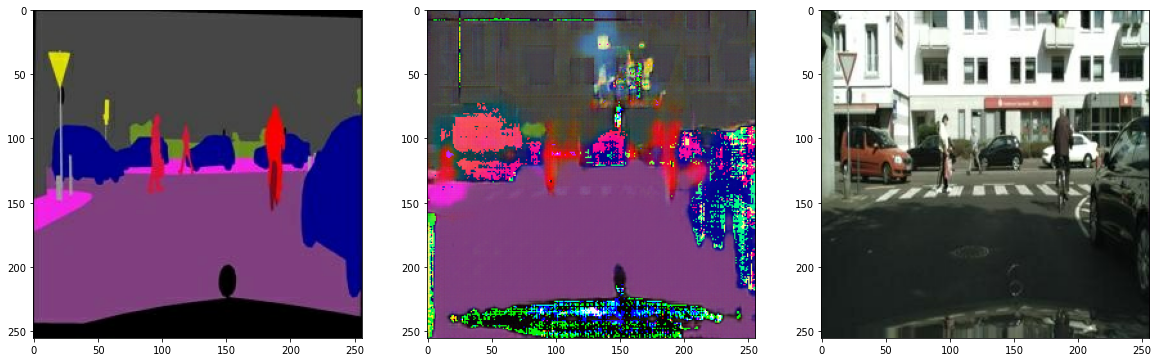

In [26]:
test_ind = 1
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'


f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(colored))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(sketch))

## 회고

Mission들을 수행
- mission 1에서는 5가지의 augmentation를 수행하였고, 2에서는 U-Net Generator를, 3에서는 val폴더 내의 이미지를 사용하였으며, 4에서는 스케치, 생성된 사진, 실제 사진 순서로 시각화하였고, 5에서 중간 손실 값에 대한 로그를 남기는데 성공하였다.



## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

- 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.

- U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.

- 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.